# Arbre binaire de recherche \[*binary search tree*\]

## Introduction

La **recherche** d'un élément donné dans une structure linéaire (liste, tableau)  est longue car on est obligé de parcourir toute la séquence. Cette opération est $O(n)$ où $n$ désigne le nombre d'éléments contenus dans la structure. 

Bien sûr, on peut **trier** une telle structure - soit au fur et à mesure des insertions, soit en appliquant un algorithme de tri - puis utiliser une **recherche dichotomique** en $O(\log n)$. Mais ces opérations de tris sont coûteuses - $O(n\log n)$ en général: dans tous les cas elles vont ralentir considérablement l'insertion et la suppression d'éléments...

Les **arbres binaires de recherche (ABR)** (*binary search tree*) - comme leur nom l'indique - sont spécialement conçus pour *accélérer* ces recherches. Ils sont le point d'entrée de structures plus évoluées - *arbres AVL*, *arbre rouge* et noir, *B-arbre* - utilisés par les systèmes de gestion de base de données par exemple.

L'idée générale est qu'un arbre binaire «équilibré» (maximum de points doubles) de taille $n$ aura des branches de longueur voisine de $\log n$; autrement dit sa **hauteur** sera proche de $\log n$.

*Par exemple*, un arbre binaire renfermant $n=1\,000$ éléments - s'il est équilibré - devrait avoir une hauteur voisine de 10 (car $2^{10}\approx 1000$), pour $n=1\,000\,000$, sa hauteur sera voisine de 20 (car $2^{20}=(2^{10})^2\approx 1000^2$) etc.

Ainsi, si nous parvenons à :
1. organiser les éléments de façon qu'on puisse les retrouver en suivant une branche
2. et à maintenir l'équilibre de l'arbre
nous les retrouverons bien plus rapidement.

Pour cela, au lieu d'exiger que les éléments soit triés, nous allons simplement leur demander de respecter un *ordre partiel*.

## Définition d'un arbre binaire de recherche

Précisément, on appelle **arbre binaire de recherche** tout arbre binaire vérifiant la condition suivante:

> **Pour tout** noeud de l'arbre, ceux de son sous-arbre:
> - gauche ont une valeur *inférieur* (ou égale),
> - droit une valeur *supérieur* (strictement).

<p style="text-align:center;">
    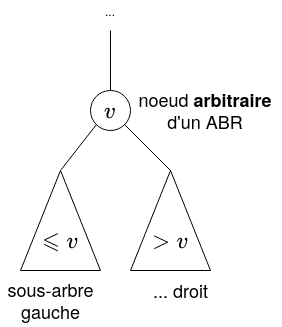
</p>

*Note*: Nous simplifions un peu car en général les valeurs des noeuds sont des *objets* qu'**on rend comparables** par un moyen ou par un autre. Cela peut être:
- en redéfinissant les opérateurs de comparaison c'est-à-dire les méthodes spéciales `__lt__` et `__eq__` au minimum (les autres du même genre sont déduites de celles-ci), 
- ou encore en précisant un attribut particulier de l'objet - qu'on désigne souvent comme la **clé** - par rapport auquel on effectue la comparaison.

Nous verrons comment faire cela plus tard. Pour l'instant nous supposerons simplement que l'attribut `v` des noeuds est directement **la clé** et pour nos tests nous utiliserons simplement des entiers.

### Exemples

Voici quelques exemples d'ABR:

<p style="text-align:center;">
    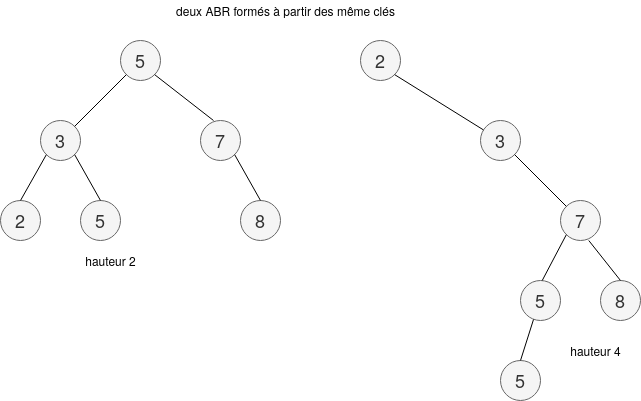
</p>

Ainsi, l'organisation interne d'un ABR ne dépend pas complètement des valeurs qu'ils renferment. Bien sûr, il est souhaitable de **minimiser sa hauteur** de façon qu'elle se rapproche le plus possible de $\log n$ (où $n$ est le nombre de noeuds).

## Opérations d'un ABR

Ce sont principalement les opérations dites de «dictionnaire»: **insérer**, **supprimer**, **chercher**.

Mais aussi quelques autres:
- *naturelles*: comme **maximum** ou *minimum*;
- *importantes algorithmiquement*: comme **successeur** ou *predecesseur*.

## Implémentation du constructeur

Pour construire ces arbres, nous réutiliserons les noeuds binaires *avec pointeur parent* `NoeudBin2`. Récupérons le code et profitons-en pour lancer la machinerie de *pytest*

In [ ]:
# «machinerie» de pytest
import pytest
import ipytest
ipytest.autoconfig()

# ajustement du sys.path
import sys, os
if not sys.path[0].endswith("code"): # pour éviter de re-modifier sys.path
    # sys.path est une liste contennant tous les dossiers où python
    # recherche les modules/paquets chargés avec import.
    # le premier d'entre eux est le répertoire courant,
    # modifions le de façon à ce qu'il pointe sur le dossier «code» du
    # répertoire courant.
    sys.path[0] = os.path.join(sys.path[0], "code")

from noeud_bin2 import NoeudBin2

Cette fois-ci, au lieu de créer une nouvelle sorte de noeud spécialisé, nous créons une classe `ABR` qui représente directement un arbre binaire de recherche. La différence? et bien un arbre peut être vide contrairement à un noeud...

### paramètre du constructeur: `keyfn`

Nous gérerons aussi une autre subtilité: la valeur portée par un noeud n'est pas nécessairement un entier; elle peut être de n'importe quel type. La seule chose que nous supposons est que:

> un ABR donné renferme toujours des objets de **même type**.

Ainsi, nous qualifierons d'**objet** la *valeur portée par un noeud* et de **clé**, ce qui *dans un tel objet*, sert à effectuer les comparaisons dans l'ABR. Je répète:

> on appelle **clé** ce qui, dans un objet stocké dans l'ABR, sert à effectuer les *comparaisons*.

Pour cette raison, l'initialisateur de `ABR` peut recevoir une fonction en argument. Cette fonction - `keyfn` sert à renvoyer la **clé** d'un objet qu'on lui fourni en argument.

### Exemple de `keyfn`

Par exemple, si les objets à stocker dans l'ABR sont des dictionnaires de la forme:

        {"prenom": ..., "nom": ..., "age": ...}
        
et qu'on considère (c'est un choix!) que la clé est `"prénom"` alors on peut prendre comme `keyfn` la fonction suivante:

```python
def keyfn(obj):
    return obj["prenom"]
```

### Constructeur

Les attributs de notre `ABR` sont:
- sa **racine** (type `NoeudBin2`): initialement `None`
- sa **taille**: mieux vaut éviter de la calculer (cela obligerait à parcourir tout l'arbre).
- sa «**cle**»: fonction qui prend un noeud (et *non un objet*) et utilise `keyfn` pour renvoyer sa clé au sens expliqué plus tôt.

In [ ]:
class ABR:
    """Modélise un arbre binaire de recherche en utilisant des noeuds de type NoeudBin2.
    Si l'on souhaite stocker des «objets» dans l'arbre, il doivent être de même nature
    et il faut alors préciser comment obtenir la clé de comparaison depuis ce genre d'objet.
    Pour cela, préciser l'argument «keyfn» du constructeur:
        il doit s'agir d'une fonction qui étant donné un objet renvoie sa clé.
        
        Ex: si les objets sont des dictionnaire de la forme {"nom":..., "prenom": ..., "age": ...} 
            et que la clé choisie est "age"
            alors keyfn(obj) renverrait obj["age"].
    
    Méthodes principales d'efficacité O(hauteur de l'arbre):
        - inserer(obj): insère obj dans l'ABR
        - supprimer(obj): supprime obj de l'ABR (s'il s'y trouve)
        - chercher(obj): renvoie True ou False selon que obj est dans l'ABR ou non
        - maximum(): renvoie l'objet contenant la clé la plus grande
    """
    
    def __init__(self, keyfn=lambda o: o):
        self.racine = None
        # calculer la taille d'un arbre est coûteux donc
        # mieux vaut tenir à jour cette information.
        self.taille = 0
        # de façon générale, un arbre binaire peut contenir n'importe quelle sorte d'objet
        # la fonction keyfn prend un tel objet et renvoie sa «clé»
        # l'attribut cle est une fonction qui, étant donné un noeud
        # renvoie la clé de l'objet stocké dans son attribut valeur.
        self.cle = lambda n: keyfn(n.valeur)
    
    def __len__(self):
        return self.taille

## Implémentation de `maximum`

Cette méthode sans paramètre qui renvoie l'objet de l'arbre ayant la plus grande clé est assez simple si vous observez attentivement quelques exemples d'ABR:

On procède en deux temps en commençant par implémenter `_maximum` qui renvoie un noeud (car c'est plus général comme nous le verrons ensuite) puis en réutilisant cette fonction pour `maximum`.

#### Exercice

Implémenter ses méthodes.

In [ ]:
def _maximum(self):
    """Renvoie le **noeud** contenant la plus grande clé ou None si l'arbre est vide."""
    pass

def maximum(self):
    """Utilise _maximum pour renvoyer l'objet contenant la plus grande clé
    ou None si l'arbre est vide."""
    pass

ABR._maximum = _maximum; ABR.maximum = maximum
del _maximum; del maximum

In [ ]:
def _maximum(self):
    """Renvoie le **noeud** contenant la plus grande clé ou None si l'arbre est vide."""
    n = self.racine
    while n.droit is not None:
        n = n.droit
    return n

def maximum(self):
    """Utilise _maximum pour renvoyer l'objet contenant la plus grande clé
    ou None si l'arbre est vide."""
    n = self._maximum()
    return None if n is None else n.valeur

ABR._maximum = _maximum; ABR.maximum = maximum
del _maximum; del maximum

## `chercher(objet)`

Cette fonction «prédicat» renvoie un *booléen* pour indiquer si l'objet est stocké dans l'arbre.

L'algorithme ressemble beaucoup à de la dichotomie ...

Comme pour `maximum`, on commence par implémenter `_chercher(obj)` qui renvoie le noeud contenant `obj` si un tel noeud existe puis on réutilise celle-ci pour `chercher` et `__contains__` qui implémente l'opérateur `in`.

#### Exercice

Implémenter ses méthodes.

In [ ]:
def _chercher(self, o):
    """Renvoie le noeud contenant l'objet fourni en argument s'il est stocké
    dans l'arbre; sinon renvoie None."""
    pass

def chercher(self, o):
    """Renvoie True ou False selon si l'objet fourni est stocké dans l'arbre ou non."""
    pass

def __contains__(self, o):
    """Permet la syntaxe naturelle «o in abr» où abr est de type ABR."""
    pass

ABR._chercher = _chercher; ABR.chercher = chercher; ABR.__contains__ = __contains__
del _chercher; del chercher; del __contains__

In [ ]:
def _chercher(self, o):
    """Renvoie le noeud contenant l'objet fourni en argument s'il est stocké
    dans l'arbre; sinon renvoie None."""
    n = self.racine
    while n is not None:
        co = self.cle(NoeudBin2(o))
        cn = self.cle(n)
        if co == cn:
            return n
        elif co < cn:
            n = n.gauche
        else:
            n = n.droit
    return None

def chercher(self, o):
    """Renvoie True ou False selon si l'objet fourni est stocké dans l'arbre ou non."""
    n = self._chercher(o)
    return False if n is None else True

def __contains__(self, o):
    """Permet la syntaxe naturelle «o in abr» où abr est de type ABR."""
    return self.chercher(o)

ABR._chercher = _chercher; ABR.chercher = chercher; ABR.__contains__ = __contains__
del _chercher; del chercher; del __contains__

## `inserer(obj)`

L'objectif ici est d'insérer un objet dans un arbre binaire de façon à **conserver sa propriété d'arbre binaire**:

> **Pour tout** noeud de l'arbre, ceux de son sous-arbre:
> - gauche ont une clé *inférieure* (ou égale),
> - droit une clé *supérieure* (strictement).

Voici un exemple où on insère un objet de clé **13**:

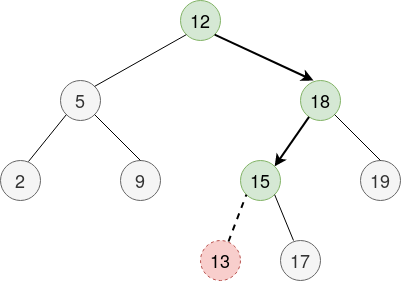

Voyez-vous la «descente» guidée, à chaque noeud rencontré, par une simple comparaison avec la clé à insérer?

In [ ]:
def inserer(self, o):
    """Insère un noeud dont la valeur est l'objet fourni o dans l'ABR."""
    x = NoeudBin2(o)
    self.taille += 1
    
    # cas où l'arbre est vide
    if ...:
        pass
    
    # recherche du noeud où effectuer l'insertion
    gauche = True # de quel côté?
    n = self.racine
    while True: # utiliser break pour sortir
        pass
    
    # insérer effectivement
    pass

ABR.inserer = inserer; del inserer

In [ ]:
def inserer(self, o):
    """Insère un noeud dont la valeur est l'objet fourni o dans l'ABR."""
    x = NoeudBin2(o)
    self.taille += 1
    
    # cas où l'arbre est vide
    if self.taille == 1:
        self.racine = x
        return
    
    # recherche du noeud où effectuer l'insertion
    gauche = True # de quel côté?
    n = self.racine
    while True:
        if self.cle(x) <= self.cle(n):
            if n.gauche:
                n = n.gauche
            else:
                break
        else:
            if n.droit:
                n = n.droit
            else:
                gauche = False
                break
        
    x.parent = n
    if gauche:
        n.gauche = x
    else:
        n.droit = x

ABR.inserer = inserer; del inserer

## Et les tests m'sieur???

Oui, oui ça arrive: mais sans `inserer`, ils sont pénibles à écrire! Vous allez enfin pouvoir **mettre votre code à l'épreuve** rapidement car je ne vous demande pas de les écrire pour une fois.

Commençons par quelques «fixtures»:

In [ ]:
@pytest.fixture()
def l():
    return [15, 6, 3, 2, 4, 7, 13, 9, 18, 20, 17]

@pytest.fixture()
def abr1(l):
    abr = ABR()
    for v in l:
        abr.inserer(v)
    return abr

@pytest.fixture()
def abr2(l):
    from random import shuffle
    abr = ABR()
    shuffle(l)
    for v in l:
        abr.inserer(v)
    return abr

#### Exercice

Dessiner l'ABR correspond à la fixture `abr1`.

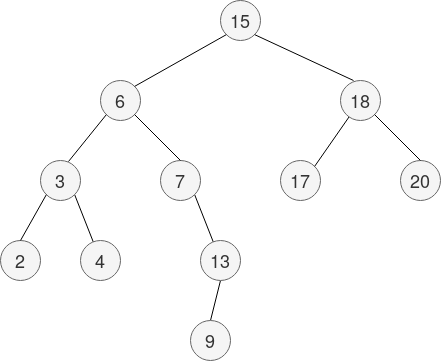

Votre objectif est de passer les tests qui suivent. Il faudra probablement quelques retouches...

In [ ]:
%%run_pytest[clean]

def test_maximum(abr1, abr2):
    assert abr1.maximum() == 20
    assert abr2.maximum() == 20

def test_chercher(abr1, l):
    for v in l:
        assert abr1.chercher(v)
    assert not abr1.chercher(0)

## Notion de successeur d'un noeud

Dans une série de valeur contenant $v$, celle qui lui **succède** est:
- la plus petite valeur parmi
- toute celles qui sont plus grande que $v$.

Par exemple, dans la série $13, 3, 11, 15, 7, 6, 12$ la valeur qui succède à $7$ est $11$:
- celles qui sont supérieures à $7$: $13, 11, 15, 12$
- la plus petite parmi celles-ci est $11$ qui succède donc à $7$.

De même, dans un ABR, le **successeur** d'un noeud `n` est le noeud dont:
- la clé est la plus petite parmi
- tous les noeuds ayant une clé supérieur à celle de `n`.

#### algorithme

Pour trouver le successeur d'un noeud `n`, il y a deux cas à considérer:

**cas 1**: `n` a un fils droit.

> Dans ce cas son successeur est le *noeud minimum de son sous-arbre droit*.

**cas 2**: `n` n'a pas de fils droit.

> son successeur éventuel est alors **parmi ses ancêtres** et `n` doit-être son **prédecesseur** car:
>
> dire que «`n'` est le successeur de `n`» revient à dire que «`n` est le prédecesseur de `n'`».

Récapitulons le tout en image:

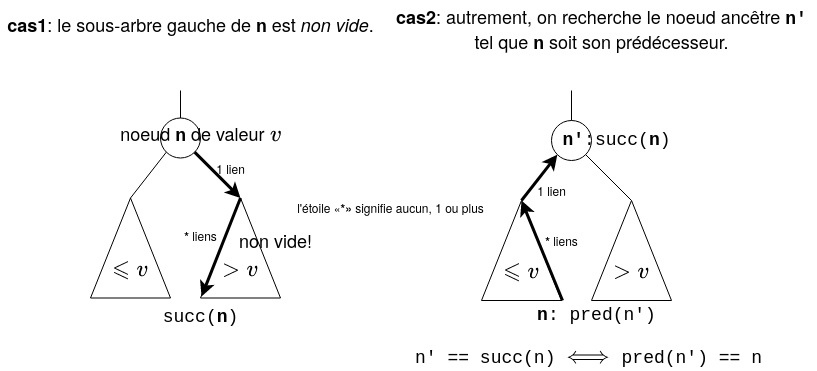

#### Exercice

Implémenter puis utiliser le test qui suit.

In [ ]:
def _succ(self, n):
    """Renvoie le noeud successeur du noeud n fourni en argument
    ou None s'il n'en a pas."""
    # 1er cas: si n a un fils droit
    if n.droit is not None:
        # trouver le minimum du sous-arbre enraciné en n.droit
        pass
    
    # 2eme cas: n est le prédecesseur du noeud cherché qui est parmi ses ancêtre
    x = n
    # tant que x est un fils droit, remonter
    while ...:
        pass
    
    # De deux choses l'une: x n'a pas de parent ou c'est un fils gauche
    
    # dans le premier cas:
    pass

    # dans le second cas:
    pass

ABR._succ = _succ; del _succ

In [ ]:
def _succ(self, n):
    """Renvoie le noeud successeur du noeud n fourni en argument
    ou None s'il n'en a pas."""
    # 1er cas: si n a un fils droit
    if n.droit is not None:
        # trouver le minimum du sous-arbre enraciné en n.droit
        x = n.droit
        while x.gauche is not None:
            x = x.gauche
        return x
    
    # 2eme cas: n est le prédecesseur du noeud cherché qui est parmi ses ancêtre
    x = n
    # tant que x est un fils droit, remonter
    while x.parent and x.parent.droit == x:
        x = x.parent
    # De deux choses l'une: x n'a pas de parent ou c'est un fils gauche
    # dans le premier cas:
    if x.parent is None:
        # x est la racine donc pas de successeur pour n
        return None
    # dans le second cas:
    return x.parent

ABR._succ = _succ; del _succ

Pour tester votre implémentation.

In [ ]:
%%run_pytest[clean]

def test__succ(abr1, abr2, l):
    l.sort()
    n1, n2 = abr1._minimum(), abr2._minimum()
    l1, l2 = [n1.valeur], [n2.valeur]
    N = len(l)
    for _ in range(N-1):
        n1, n2 = abr1._succ(n1), abr2._succ(n2)
        l1.append(n1.valeur); l2.append(n2.valeur)
    assert l1 == l
    assert l2 == l

## `supprimer(obj)`

La suppression d'un noeud n'est pas tout à fait évidente car il ne faut pas violer la *propriété d'arbre binaire de recherche*.

#### Algorithme

On distingue trois cas selon la sorte de noeud `n` à supprimer:

**1er cas**: `n` est une feuille.

> il suffit de faire pointer son parent vers None à la place de ce noeud.

**2e cas**: `n` est simple (un seul enfant non vide).

> il suffit de faire pointer son parent vers son unique enfant et vice versa.

**3e cas**: `n` est double.

> dans ce cas, `n'`, le successeur de `n`, est un de ses descendants. De plus, il s'agit nécessairement d'une feuille ou d'un noeud simple (pourquoi?).
>
> On suit alors la stratégie suivante: on écrase la valeur de `n` avec celle de `n'` puis on supprime `n'` ce qui nous ramène à l'un des deux premiers cas.

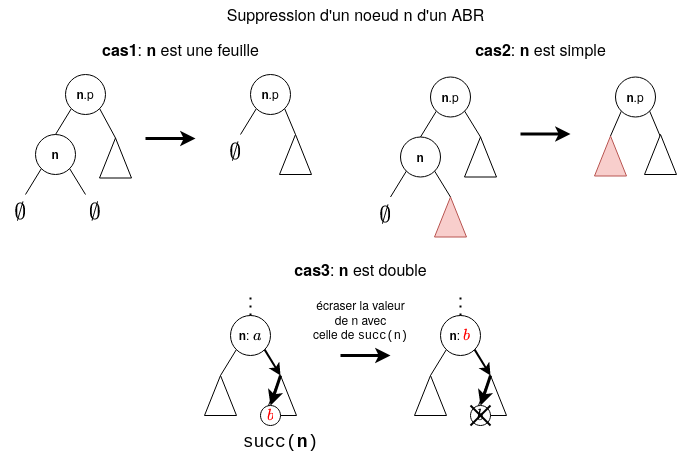

#### Exercice

Implémenter en suivant attentivement les commentaires puis utiliser le test qui suit pour vérifier votre solution.

In [ ]:
def _supprimer(self, noeud):
    """Supprime le noeud fourni en argument (supposé dans l'ABR)"""
    
    if self.taille == 0:
        return
    self.taille -= 1
    
    n = noeud # n désigne le noeud à supprimer in fine
    # cas3: n est double
    if n.est_double():
        # remplacer n par son successeur
        n = ___
        # puis écraser la valeur noeud avec celle de son successeur
        pass
    
    # à partir de là, on peut supposer que n n'est pas double
    
    # récupérons le fils éventuel de n à rattacher à son parent
    f = ___
    
    # si n est la racine, f devient la nouvelle racine
    pass
    
    # soit p le parent de n
    p = n.parent
    
    
    # si le fils de n n'est pas None, il faut le faire pointer vers son nouveau parent
    pass
    
    # f doit-il être le fils gauche ou droit de p (si p n'est pas None)
    if p is not None:
        pass
    
    n.parent = None; n.gauche = None; n.droit = None # ménage!
    return ____

def supprimer(self, o):
    """Supprime l'objet fourni en argument s'il se trouve dans l'ABR.
    Autrement, n'a pas d'effet."""
    pass

ABR._supprimer = _supprimer; ABR.supprimer = supprimer
del _supprimer; del supprimer

In [ ]:
def _supprimer(self, noeud):
    """Supprime le noeud fourni en argument (supposé dans l'ABR)"""
    
    if self.taille == 0:
        return
    
    self.taille -= 1
    n = noeud # n désigne le noeud à supprimer in fine
    if n.est_double():
        n = self._succ(noeud)
        # copions la valeur de succ(noeud) dans noeud
        noeud.valeur = n.valeur
    
    # à partir de là, on peut supposer que n n'est pas double
    
    # récupérons le fils éventuel de n à rattacher à son parent
    f = n.droit if n.gauche is None else n.gauche
    
    # si n est la racine, f devient la nouvelle racine
    if not n.parent:
        self.racine = f
    
    # soit p le parent de n
    p = n.parent
    
    
    # si le fils de n n'est pas None, il faut le faire pointer vers son nouveau parent
    if f is not None:
        f.parent = p
    
    # f doit-il être le fils gauche ou droit de p (si p n'est pas None)
    if p is not None:
        if p.gauche == n:
            p.gauche = f
        else:
            p.droit = f
    n.parent = None; n.gauche = None; n.droit = None # ménage!
    return n.valeur

def supprimer(self, o):
    """Supprime l'objet fourni en argument s'il se trouve dans l'ABR.
    Autrement, n'a pas d'effet."""
    n = self._chercher(o)
    if n is not None:
        self._supprimer(n)

ABR._supprimer = _supprimer; ABR.supprimer = supprimer
del _supprimer; del supprimer

In [ ]:
%%run_pytest[clean]

def test_supprimer(abr1, abr2, l):
    n1, n2 = len(abr1), len(abr2)
    abr1.supprimer(0); abr2.supprimer(0)
    assert len(abr1) == n1
    assert len(abr2) == n2
    for v in l:
        abr1.supprimer(v)
        abr2.supprimer(v)
    assert len(abr1) == 0
    assert abr1.racine is None
    assert len(abr2) == 0
    assert abr2.racine is None